In [2]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
ff1.Cache.enable_cache('../cache')
pd.options.mode.chained_assignment = None

In [3]:
team = 'Alpine'
driver_1 = 'OCO'
driver_2 = 'GAS'

plt.style.use('dark_background')

In [4]:
event = ff1.get_event(2024, 1)

In [5]:
q = event.get_qualifying()
q.load()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.3.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']


In [6]:
corners = q.get_circuit_info().corners['Distance']

# Comparison of team drivers

In [7]:
laps_team = q.laps.pick_team(team)
laps_d1 = laps_team.pick_driver(driver_1)
laps_d2 = laps_team.pick_driver(driver_2)

In [8]:
print("Fastest D1 : ", laps_d1.pick_fastest()['LapTime'])
print("Fastest D2 : ", laps_d2.pick_fastest()['LapTime'])

Fastest D1 :  0 days 00:01:30.793000
Fastest D2 :  0 days 00:01:30.948000


In [9]:
# Telemetry comparison
from fastf1 import utils

deltas, tel_d1, tel_d2 = utils.delta_time(
    laps_d1.pick_fastest(),
    laps_d2.pick_fastest()
)

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


In [10]:
tel_d1['Time'] = tel_d1['Time'].dt.total_seconds()
tel_d2['Time'] = tel_d2['Time'].dt.total_seconds()

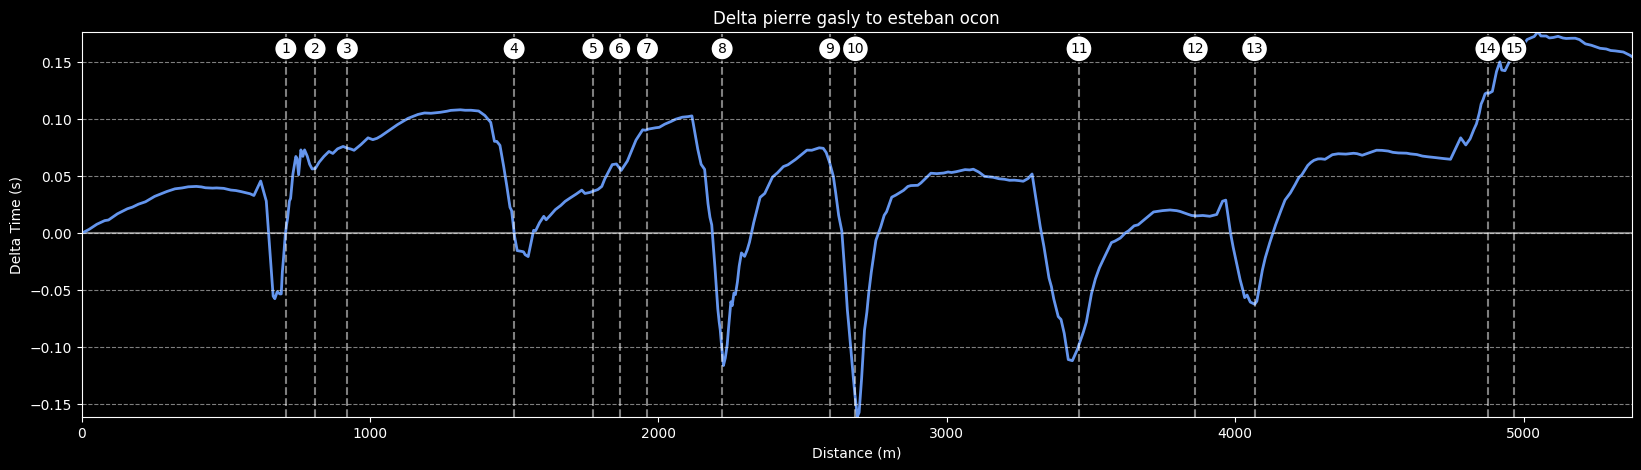

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from fastf1 import plotting

fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()

min_y = min(deltas)
max_y = max(deltas)

max_x = max(tel_d1['Distance'])

ax.plot(
    tel_d1['Distance'],
    deltas,
    color='cornflowerblue',
    linewidth=2,
    zorder=1
)

i = 1
for corner_distance in corners:
    ax.vlines(corner_distance, min_y, max_y, linestyles='dashed', alpha=0.5)
    ax.text(
        corner_distance,
        max_y * 0.95,
        f'{i}',
        color='black',
        verticalalignment='top',
        horizontalalignment='center',
        bbox=dict(facecolor='white', alpha=1, boxstyle='circle', edgecolor='black')
        )
    i += 1

ax.hlines(0, 0, max_x, zorder=-1, alpha=0.5)

ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Delta Time (s)')
ax.set_xlim(0, max_x)
ax.set_ylim(min_y, max_y)
plt.title('Delta ' + plotting.DRIVER_TRANSLATE[driver_2] + ' to ' + plotting.DRIVER_TRANSLATE[driver_1])
plt.show()


In [147]:
import matplotlib.pyplot as plt
import pandas as pd
from fastf1 import plotting

def plot_lap_telemetry(data_d1, data_d2, column, ax = None, min_distance = -np.Infinity, max_distance = np.Infinity, y_padding = 0, d1_color = 'cornflowerblue', d2_color = 'crimson'):
    if ax == None:
        ax = plt.subplot()
    data_d1 = data_d1[(data_d1['Distance'] > min_distance) & (data_d1['Distance'] < max_distance)]
    data_d2 = data_d2[(data_d2['Distance'] > min_distance) & (data_d2['Distance'] < max_distance)]
    
    min_y = min(data_d1[column] - y_padding)
    max_y = max(data_d1[column] + y_padding)

    min_x = max(0, min_distance)
    max_x = min(max(data_d1['Distance']), max_distance)

    ax.plot(
        data_d1['Distance'],
        data_d1[column],
        color=d1_color,
        linewidth=2,
        zorder=1,
        label=driver_1
    )

    ax.plot(
        data_d2['Distance'],
        data_d2[column],
        color=d2_color,
        linewidth=2,
        zorder=1,
        label=driver_2
    )

    i = 0
    for corner_distance in corners:
        i += 1
        if (corner_distance < min_distance) | (corner_distance > max_distance):
            continue
        ax.vlines(corner_distance, min_y, max_y, linestyles='dashed', alpha=0.5)
        ax.text(
            corner_distance,
            max_y * 0.95,
            f'{i}',
            color='black',
            verticalalignment='top',
            horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=1, boxstyle='circle', edgecolor='black')
            )

    ax.hlines(0, 0, max_x, zorder=-1, alpha=0.5)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.legend(loc='lower right')

    ax.set_ylabel('Speed (kph)')
    return ax


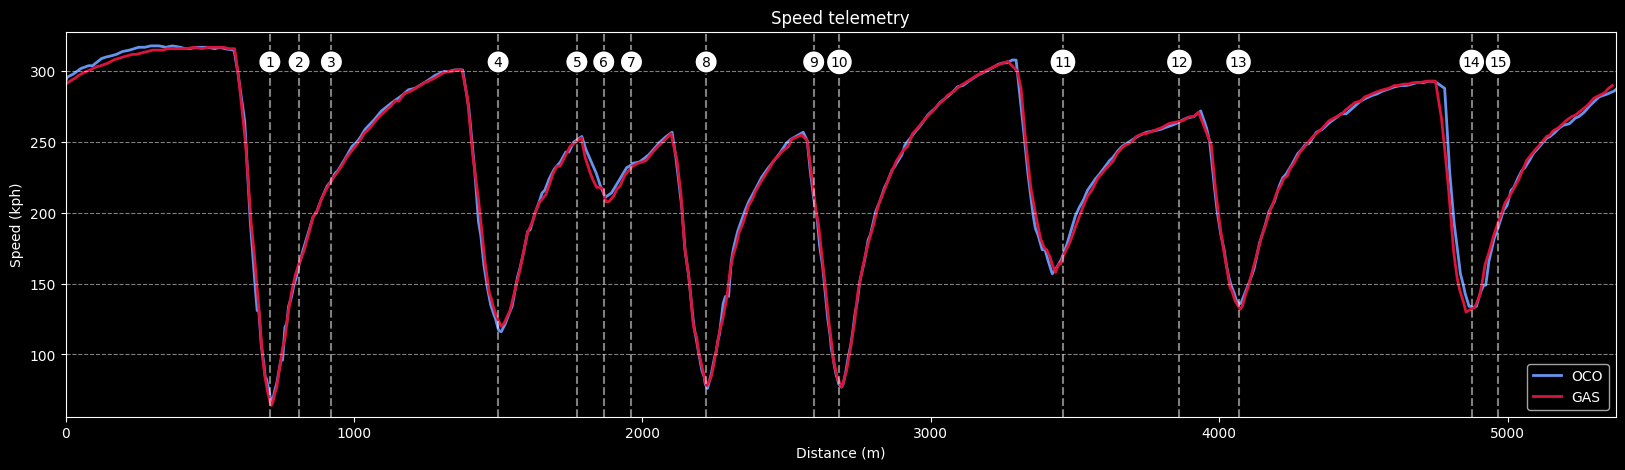

In [13]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (kph)')
plt.title('Speed telemetry')
ax = plot_lap_telemetry(
    tel_d1,
    tel_d2,
    'Speed',
    ax,
    y_padding=10,
)
plt.show()

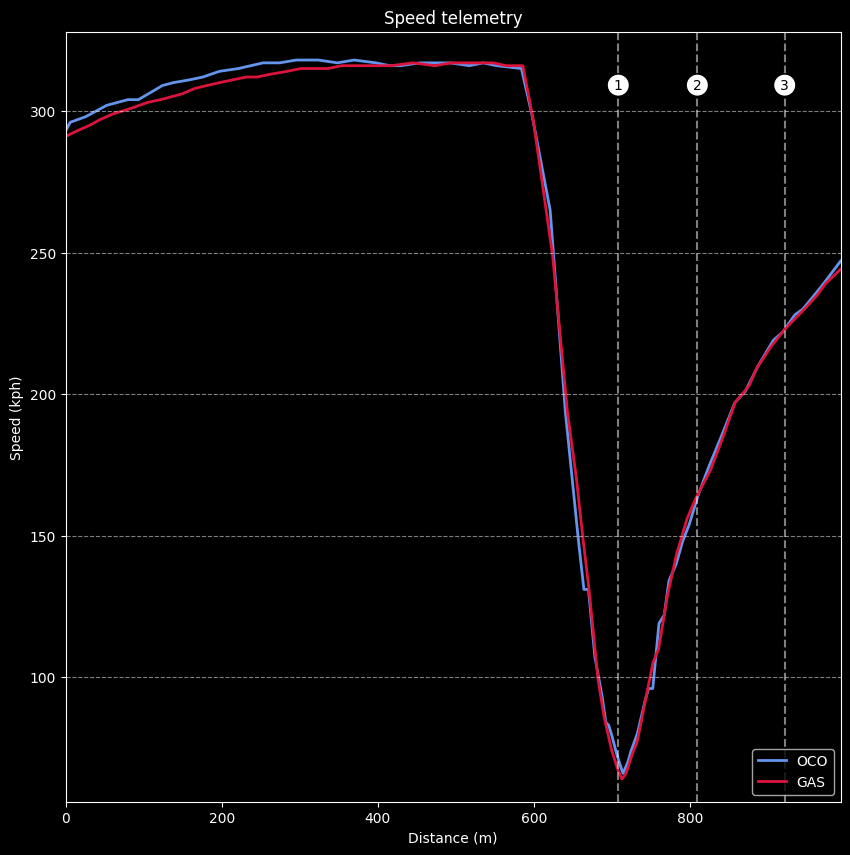

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (kph)')
plt.title('Speed telemetry')
ax = plot_lap_telemetry(
    tel_d1,
    tel_d2,
    'Speed',
    ax,
    y_padding=10,
    max_distance=1000
)
plt.show()

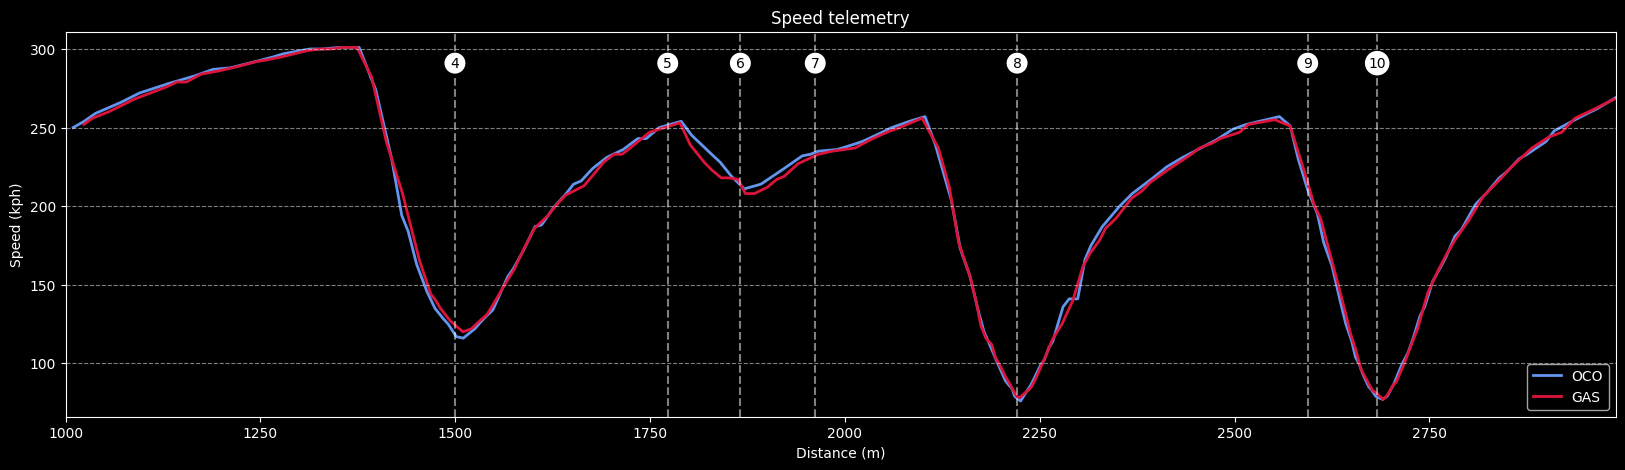

In [15]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (kph)')
plt.title('Speed telemetry')
ax = plot_lap_telemetry(
    tel_d1,
    tel_d2,
    'Speed',
    ax,
    y_padding=10,
    min_distance=1000,
    max_distance=3000
)
plt.show()

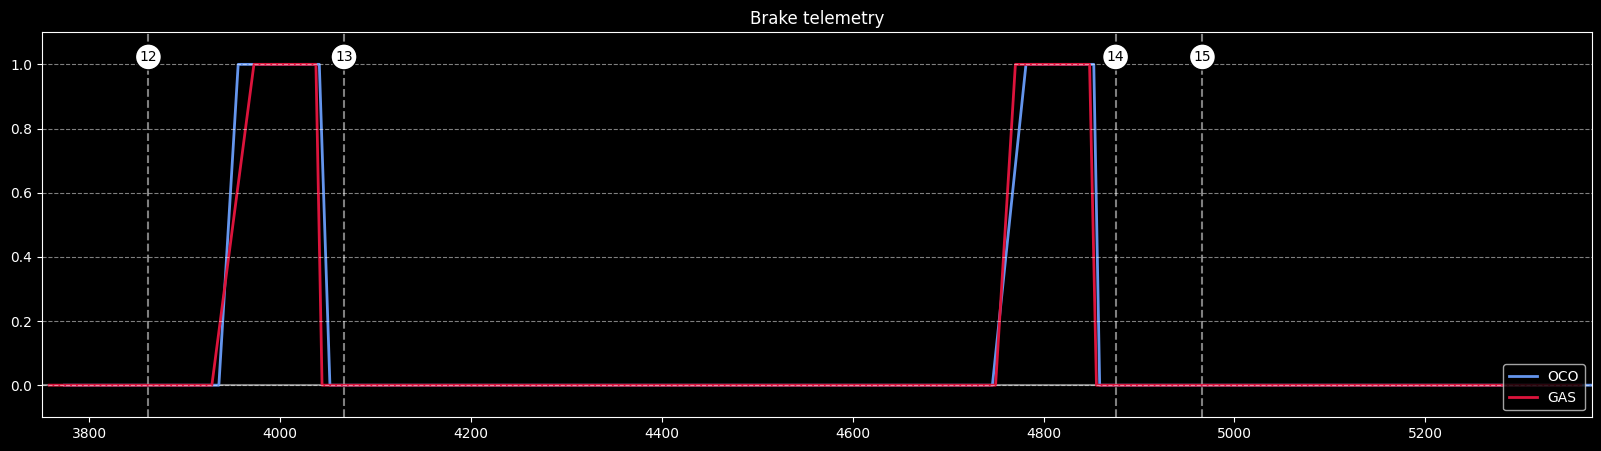

In [16]:
plt.figure(figsize=(20, 5))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Brake (%)')
plt.title('Brake telemetry')
ax = plot_lap_telemetry(
    tel_d1,
    tel_d2,
    'Brake',
    ax,
    y_padding=0.1,
    min_distance=3750,
)
plt.show()

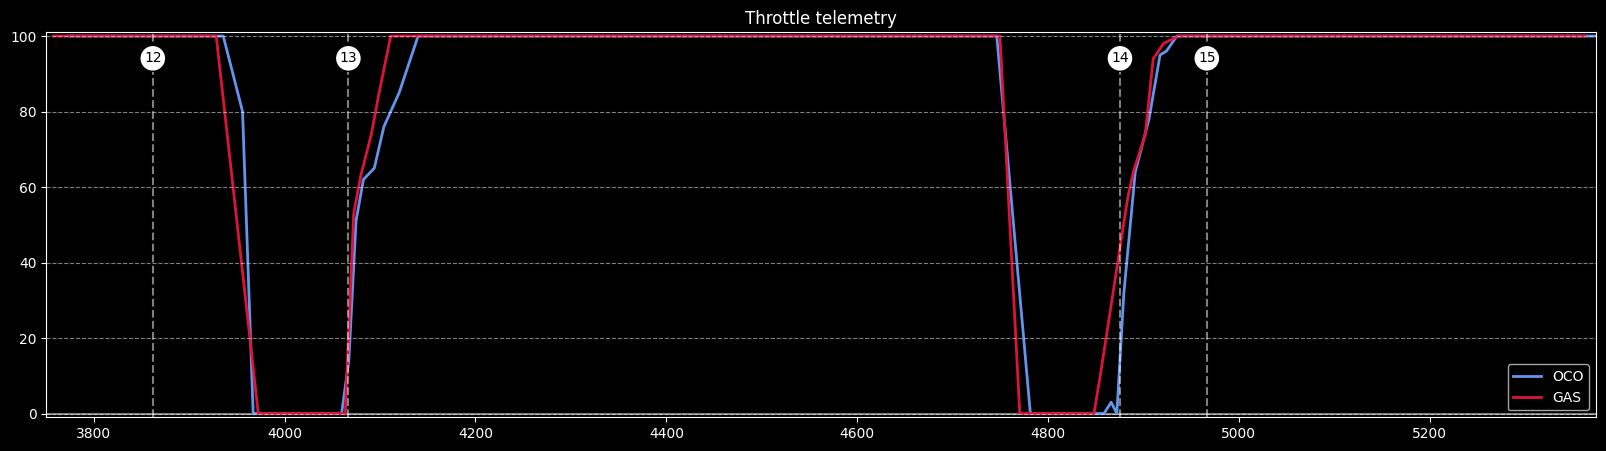

In [17]:
plt.figure(figsize=(20, 5))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Throttle (%)')
plt.title('Throttle telemetry')
ax = plot_lap_telemetry(
    tel_d1,
    tel_d2,
    'Throttle',
    ax,
    y_padding=1,
    min_distance=3750,
)
plt.show()

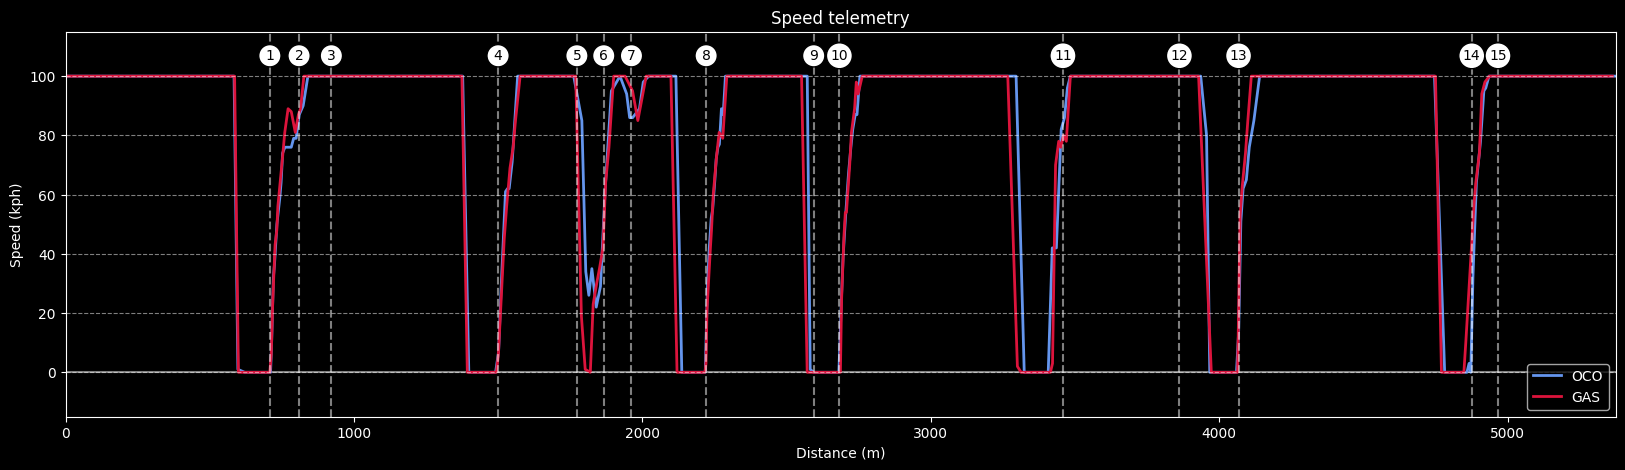

In [18]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (kph)')
plt.title('Speed telemetry')
ax = plot_lap_telemetry(
    tel_d1,
    tel_d2,
    'Throttle',
    ax,
    y_padding=15,
)
plt.show()

# Comparison between the team and others

In [88]:
# Take Q1 end as session cut off
q1 = q.laps[q.laps['Time'] < q._session_split_times[1]]

q1_fastests = pd.DataFrame([q1.pick_team(team).pick_fastest() for team in q.laps['Team'].unique()])
q1_fastests.sort_values('LapTime', inplace=True)  
q1_fastests['LapTimeSeconds'] = q1_fastests['LapTime'].dt.total_seconds()
q1_fastests['S1'] = q1_fastests['Sector1Time'].dt.total_seconds()
q1_fastests['S2'] = q1_fastests['Sector2Time'].dt.total_seconds()
q1_fastests['S3'] = q1_fastests['Sector3Time'].dt.total_seconds()

q1_fastests['Color'] = q1_fastests['Team'].apply(plotting.team_color)

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_25672/1427929631.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


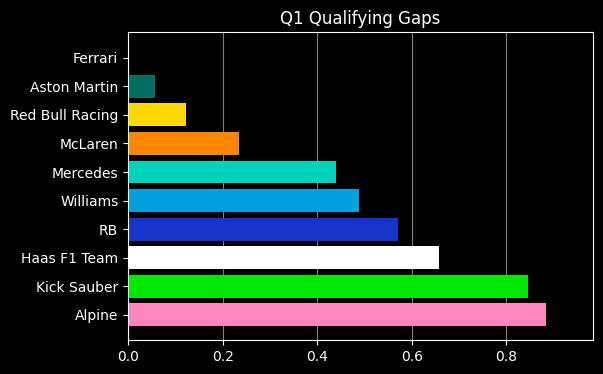

In [89]:
padding_right = 0.1

q1_fastests['DeltaFastest'] = q1_fastests['LapTimeSeconds'] - q1_fastests.iloc[0]['LapTimeSeconds']

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
plt.gca().invert_yaxis()

ax.barh(q1_fastests['Team'], q1_fastests['DeltaFastest'], color=q1_fastests['Color'], zorder=2)

ax.grid(axis='x', zorder=0, alpha=0.5)
ax.set_xlim(left=q1_fastests['DeltaFastest'].min(), right=q1_fastests['DeltaFastest'].max() + padding_right)
ax.set_title('Q1 Qualifying Gaps')
fig.show()

In [90]:
compared_lap = q1_fastests[q1_fastests['Team'] == team].iloc[0]

q1_fastests['S1Delta'] = q1_fastests['S1'] - compared_lap['S1']
q1_fastests['S2Delta'] = q1_fastests['S2'] - compared_lap['S2']
q1_fastests['S3Delta'] = q1_fastests['S3'] - compared_lap['S3']

other_laps = q1_fastests[q1_fastests['Team'] != team]

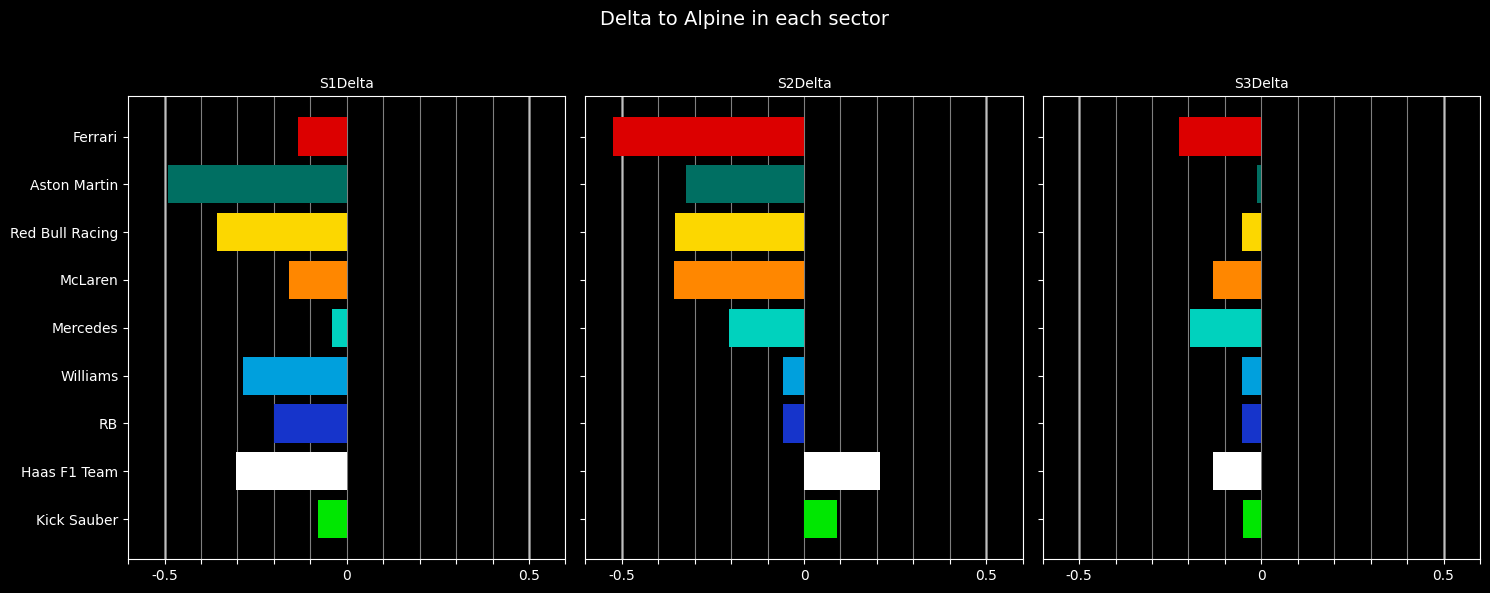

In [91]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # Ensure numpy is imported for arange function

# Assuming 'other_laps' is your DataFrame.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 6))  # Adjusted figsize for better visibility
plt.gca().invert_yaxis()

lim = (-0.6, 0.6)

def customize_axis(ax, lim, sector_name):
    ax.barh(other_laps['Team'], other_laps[sector_name], color=other_laps['Color'], zorder=2)
    ax.grid(axis='x', which='both', zorder=0, alpha=0.5)
    ax.set_xlim(lim)
    
    # Set major ticks
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(-0.6, 0.7, 0.1)))
    ax.xaxis.set_minor_locator(ticker.FixedLocator([-0.5, 0.5])) 
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(["", "-0.5", "", "", "", "", "0", "", "", "", "", "0.5"]))

    # Adding bolder lines at x=0.5 and x=-0.5
    ax.axvline(-0.5, color='grey', linewidth=2, zorder=1)  # Adjust color and linewidth as needed
    ax.axvline(0.5, color='grey', linewidth=2, zorder=1)

    # Set subtitle for each axis
    ax.set_title(sector_name, fontsize=10)  # Adjust fontsize as needed

# Customize each axis with its name as subtitle
sectors = ['S1Delta', 'S2Delta', 'S3Delta']
for ax, sector_name in zip([ax1, ax2, ax3], sectors):
    customize_axis(ax, lim, sector_name)

# Set the overall title
fig.suptitle('Delta to Alpine in each sector', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the overall title
plt.show()


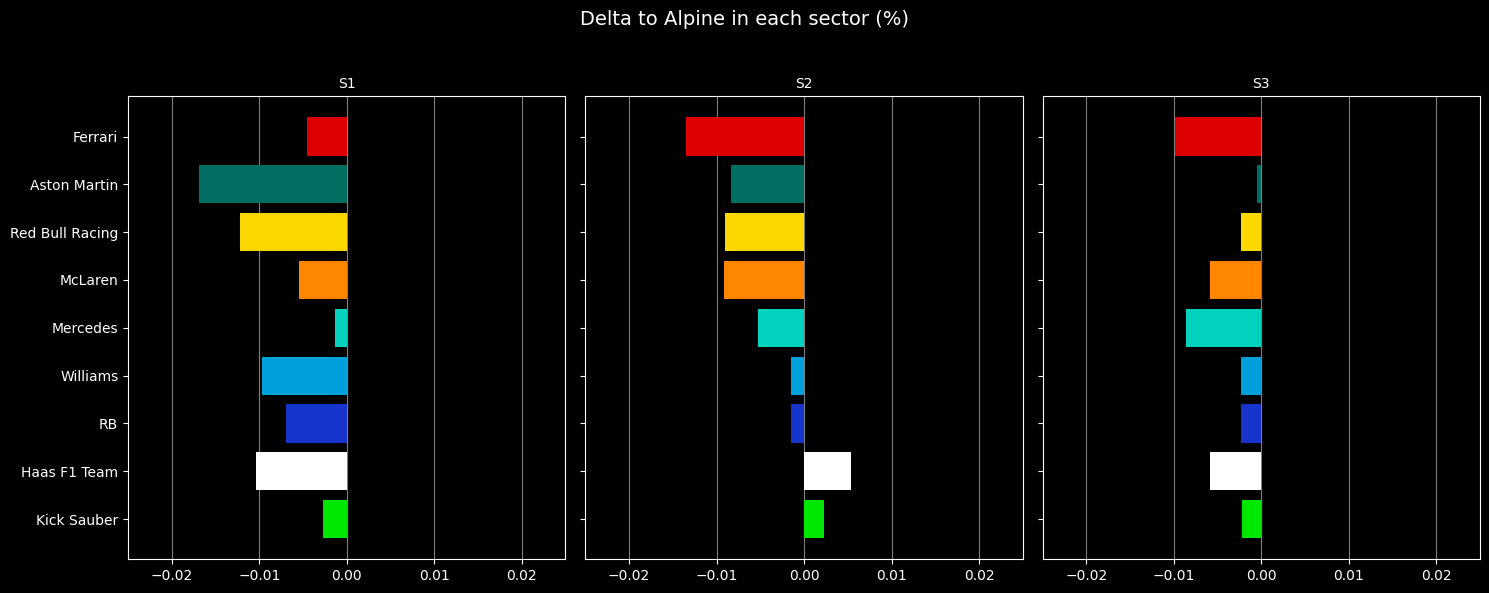

In [92]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # Ensure numpy is imported for arange function

# Assuming 'other_laps' is your DataFrame.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 6))  # Adjusted figsize for better visibility
plt.gca().invert_yaxis()

lim = (-0.025, 0.025)

def customize_axis(ax, lim, sector_name):
    ax.barh(other_laps['Team'], other_laps[sector_name] / compared_lap[sector_name] - 1, color=other_laps['Color'], zorder=2)
    ax.grid(axis='x', which='both', zorder=0, alpha=0.5)
    ax.set_xlim(lim)
    
    # Set major ticks
    #ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(-0.6, 0.7, 0.1)))
    #ax.xaxis.set_minor_locator(ticker.FixedLocator([-0.5, 0.5])) 
    #ax.xaxis.set_major_formatter(ticker.FixedFormatter(["", "-0.5", "", "", "", "", "0", "", "", "", "", "0.5"]))

    # Adding bolder lines at x=0.5 and x=-0.5
    #ax.axvline(-0.5, color='grey', linewidth=2, zorder=1)  # Adjust color and linewidth as needed
    #ax.axvline(0.5, color='grey', linewidth=2, zorder=1)

    # Set subtitle for each axis
    ax.set_title(sector_name, fontsize=10)  # Adjust fontsize as needed

# Customize each axis with its name as subtitle
sectors = ['S1', 'S2', 'S3']
for ax, sector_name in zip([ax1, ax2, ax3], sectors):
    customize_axis(ax, lim, sector_name)

# Set the overall title
fig.suptitle('Delta to Alpine in each sector (%)', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the overall title
plt.show()


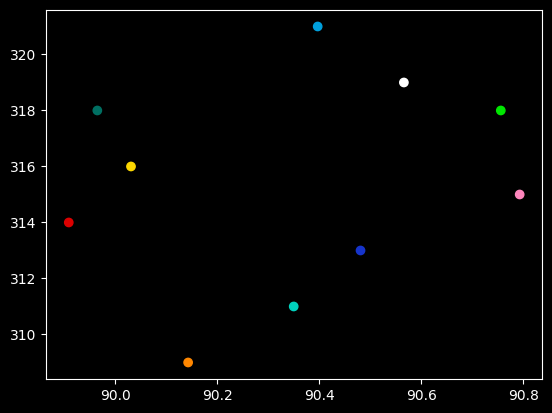

In [101]:
fig = plt.figure()
ax = plt.subplot()

ax.scatter(q1_fastests['LapTimeSeconds'], q1_fastests['SpeedST'], color=q1_fastests['Color'])

In [211]:
def plot_lap_telemetry_multi(datas, column, colors, labels, ax = None, min_distance = -np.Infinity, max_distance = np.Infinity, y_padding = 0, corner_numbers = True):
    if ax == None:
        ax = plt.subplot()
    
    for (i, data) in enumerate(datas):
        data = data[(data['Distance'] > min_distance) & (data['Distance'] < max_distance)]
        
        min_y = min(data[column] - y_padding)
        max_y = max(data[column] + y_padding)

        min_x = max(0, min_distance)
        max_x = min(max(data['Distance']), max_distance)

        ax.plot(
            data['Distance'],
            data[column],
            color=colors[i],
            linewidth=1,
            zorder=1,
            label = labels[i]
        )

    i = 0
    for corner_distance in corners:
        i += 1
        if (corner_distance < min_distance) | (corner_distance > max_distance):
            continue
        ax.vlines(corner_distance, min_y, max_y, linestyles='dashed', alpha=0.5)
        if corner_numbers:
            ax.text(
                corner_distance,
                max_y * 0.95,
                f'{i}',
                color='black',
                verticalalignment='top',
                horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=1, boxstyle='circle', edgecolor='black')
                )

    ax.hlines(0, 0, max_x, zorder=-1, alpha=0.5)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.legend(loc='lower right')

    ax.set_ylabel('Speed (kph)')
    return ax


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


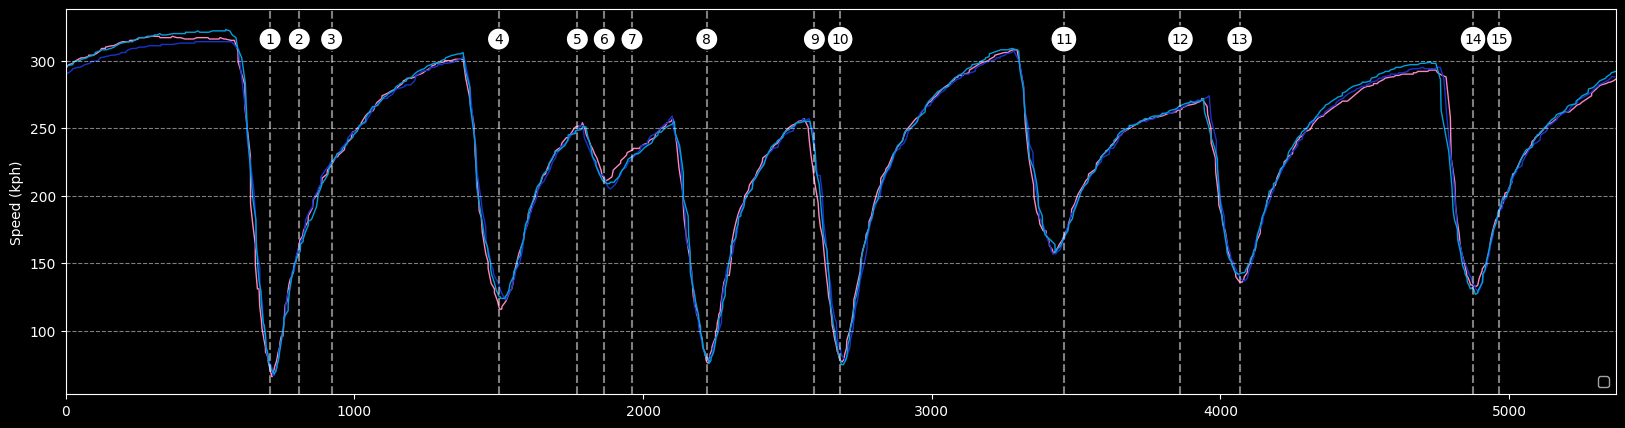

In [165]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax = plot_lap_telemetry_multi(
    [
        q1.pick_team(team).pick_fastest().get_telemetry(),
        q1.pick_team('RB').pick_fastest().get_telemetry(),
        q1.pick_team('Williams').pick_fastest().get_telemetry(),
    ],
    'Speed',
    [
        plotting.team_color('Alpine'),
        plotting.team_color('RB'),
        plotting.team_color('Williams')
    ],
    ax,
    y_padding = 15
)

In [217]:
def plot_time_delta(ax, deltas, distances, labels, colors, min_distance = -np.Infinity, max_distance = np.Infinity, y_padding = 0, corner_numbers = True):
    min_y = min([min(delta) for delta in deltas])
    max_y = max([max(delta) for delta in deltas])
    min_x = max(min_distance, 0)
    for (i, delta) in enumerate(deltas):
        max_x = min(max(distances), max_distance)

        ax.plot(
            distances,
            delta,
            color=colors[i],
            linewidth=1,
            zorder=1,
            label=labels[i]
        )

    i = 1
    for corner_distance in corners:
        ax.vlines(corner_distance, min_y, max_y, linestyles='dashed', alpha=0.5)
        if corner_numbers:
            ax.text(
                corner_distance,
                max_y * 0.95,
                f'{i}',
                color='black',
                verticalalignment='top',
                horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=1, boxstyle='circle', edgecolor='black')
                )
        i += 1

    ax.hlines(0, 0, max_x, zorder=-1, alpha=0.5)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Delta Time (s)')
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y - y_padding, max_y + y_padding)
    return ax

def plot_telemetry(df, ref_team, others, min_distance = -np.Infinity, max_distance = np.Infinity):
    deltas = []
    distances = None
    telemetry = []
    colors = []
    labels = [ref_team] + others
    for (i, other) in enumerate(others):
        delta, t1, t2 = utils.delta_time(
            df.pick_team(ref_team).pick_fastest(),
            df.pick_team(other).pick_fastest()
        )
        if i == 0:
            telemetry.append(t1)
            distances = t1['Distance']
            colors.append(plotting.team_color(ref_team))
        deltas.append(delta)
        telemetry.append(t2)
        colors.append(plotting.team_color(other))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax1 = plot_lap_telemetry_multi(
        telemetry,
        'Speed',
        colors,
        labels,
        ax1,
        y_padding = 15,
        min_distance=min_distance,
        max_distance=max_distance)
    ax2 = plot_time_delta(
        ax2, deltas, distances, labels[1:], colors[1:], y_padding=0.1,
        corner_numbers=False, min_distance=min_distance,
        max_distance=max_distance
        )
    ax1.set_title('Comparison between bottom 5 teams')
    plt.legend(loc='lower right')
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom

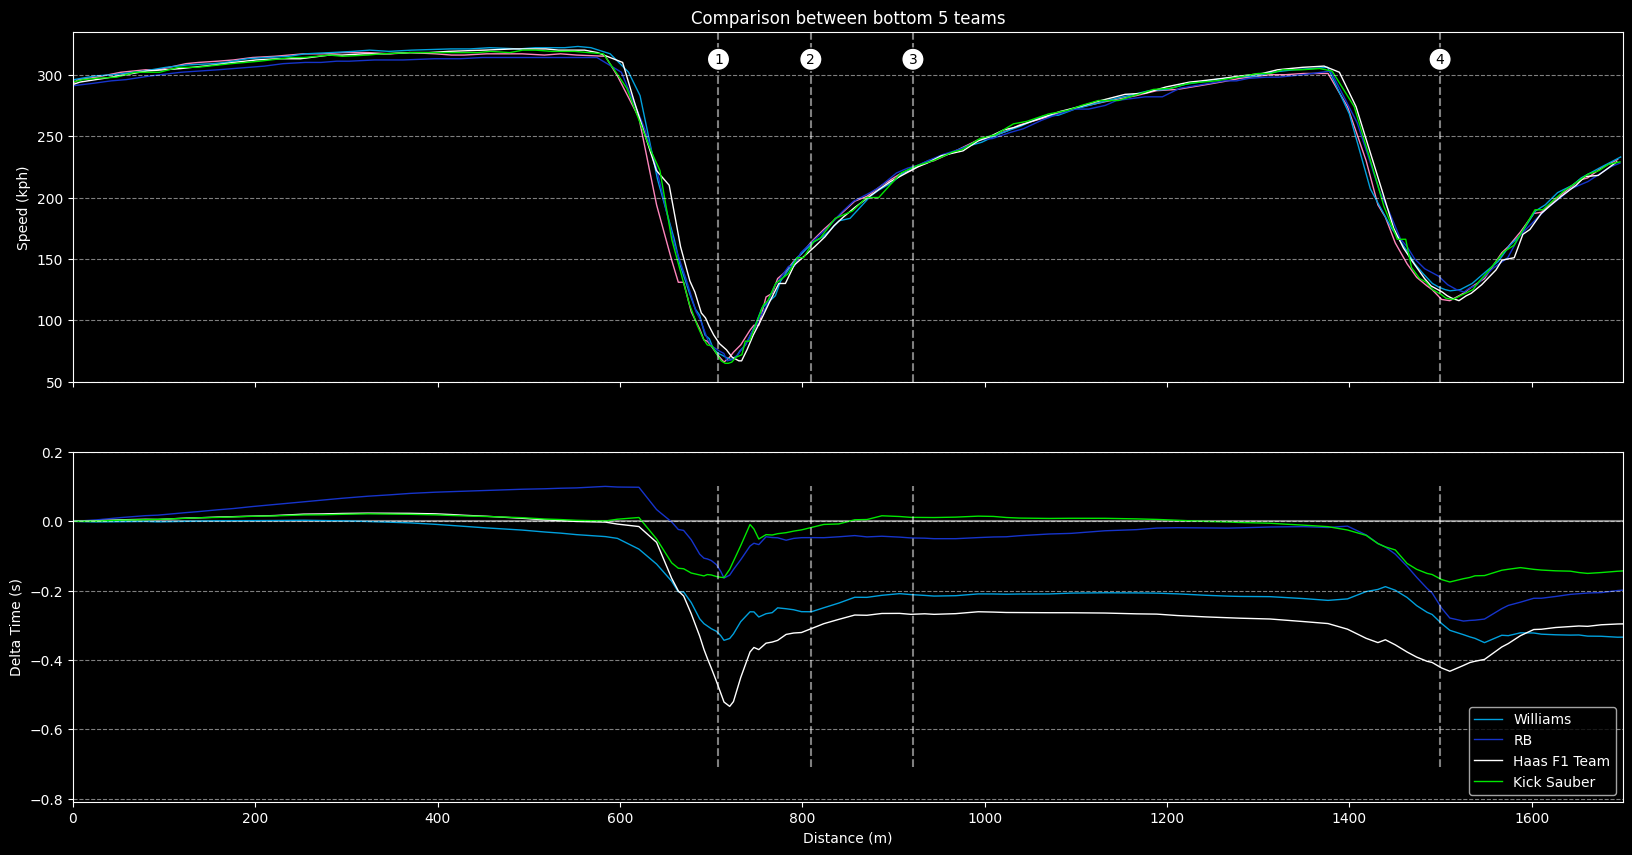

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom

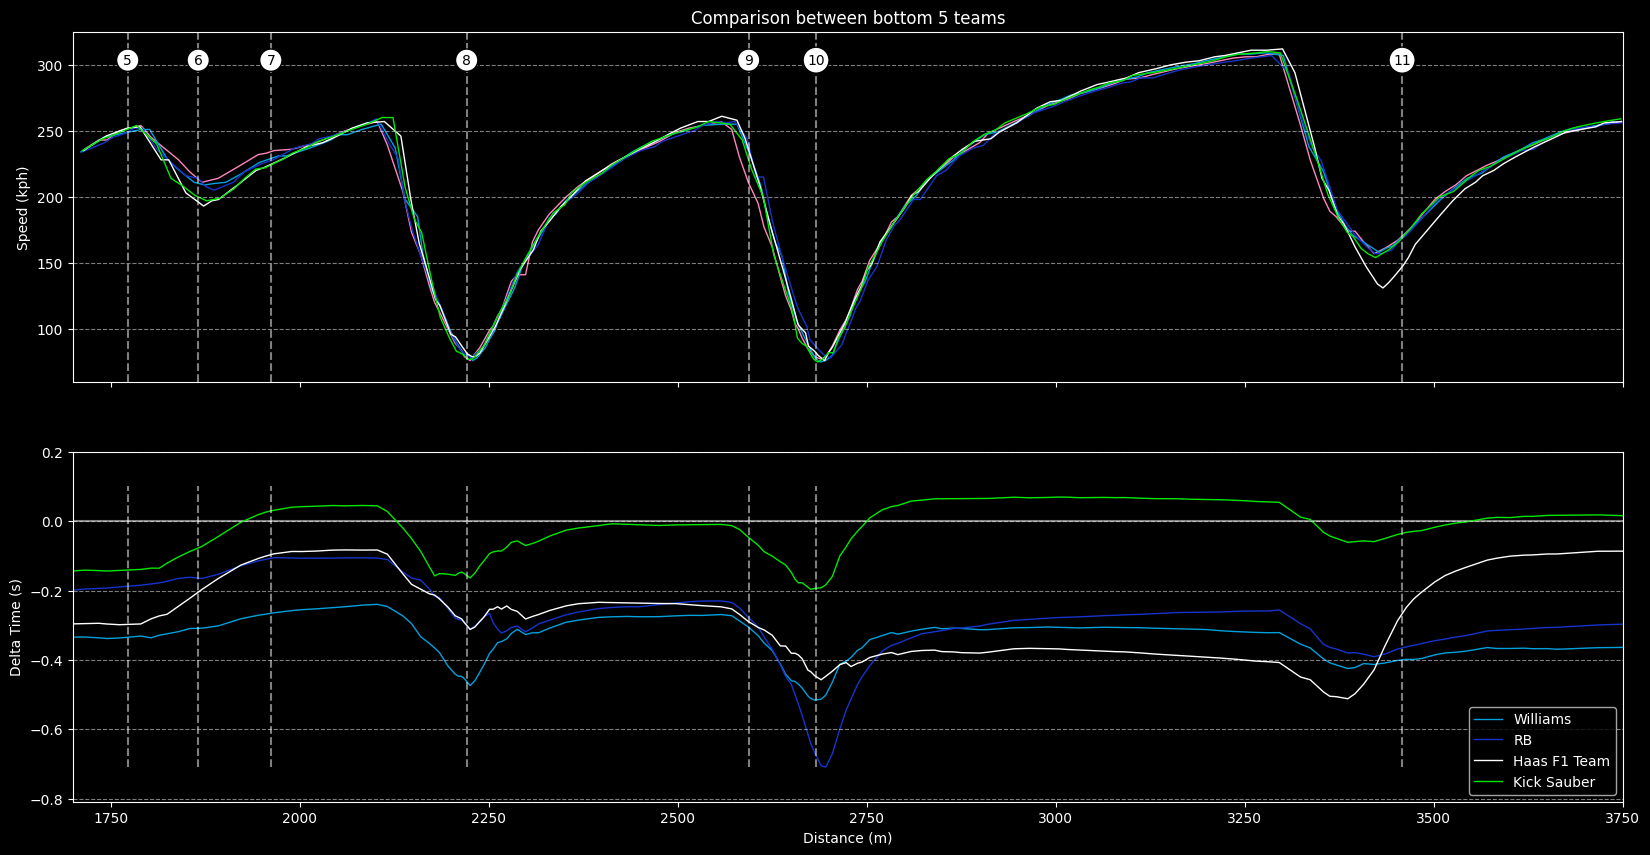

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom

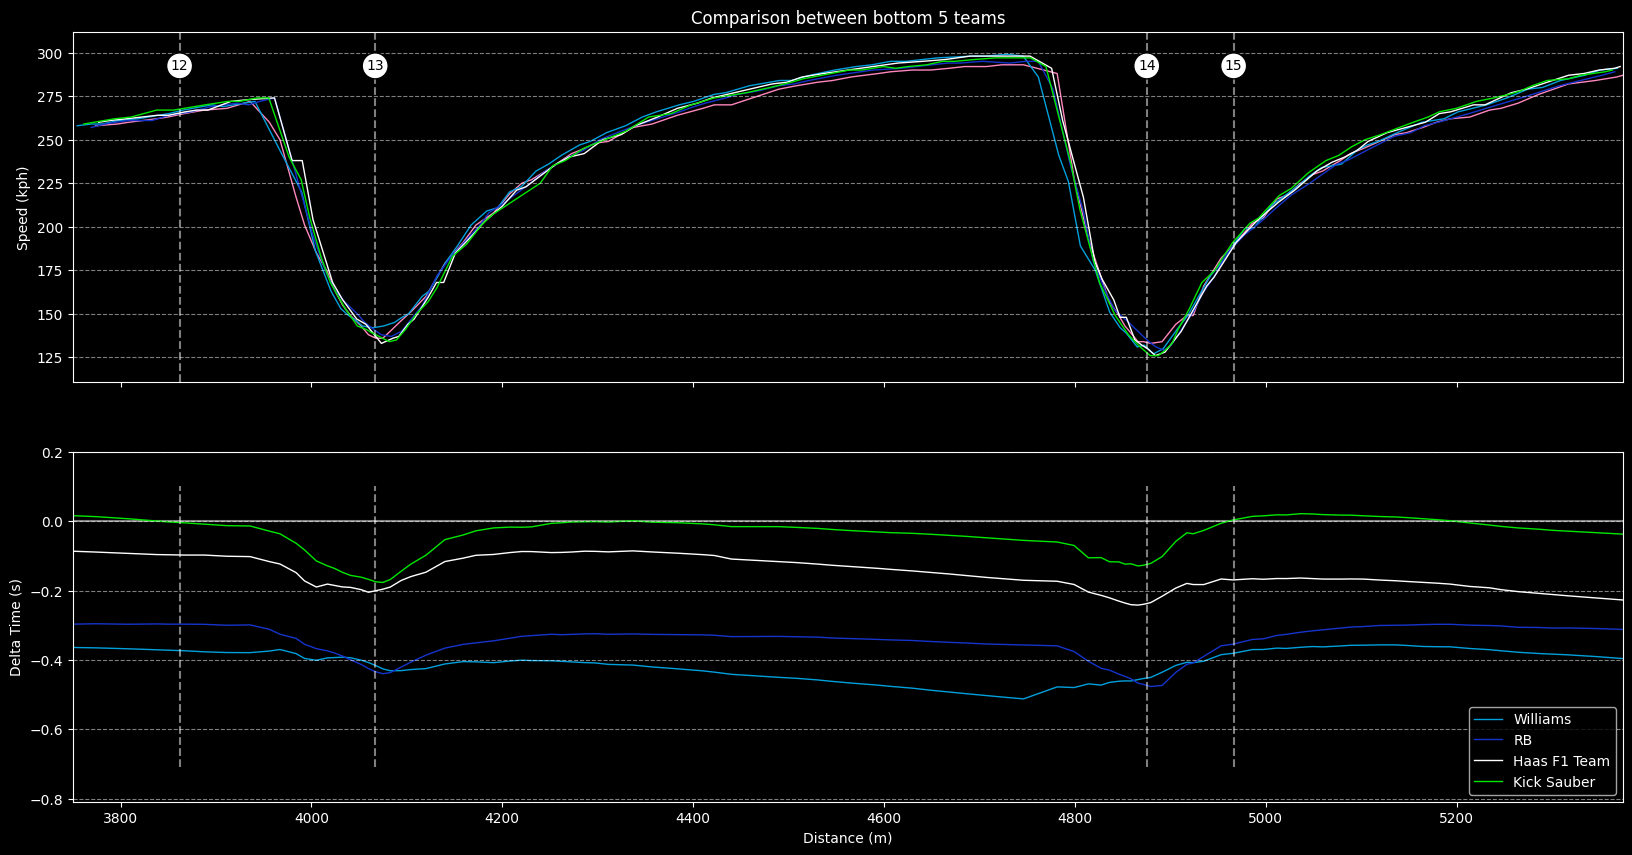

In [218]:
# Sector 1
plot_telemetry(
    q1,
    team,
    q1_fastests[q1_fastests['Team'] != team]['Team'][5:].to_list(),
    max_distance=1700
)
# Sector 2
plot_telemetry(
    q1,
    team,
    q1_fastests[q1_fastests['Team'] != team]['Team'][5:].to_list(),
    min_distance=1700,
    max_distance=3750
)
# Sector 3
plot_telemetry(
    q1,
    team,
    q1_fastests[q1_fastests['Team'] != team]['Team'][5:].to_list(),
    min_distance=3750,
)